In [95]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [96]:
import gymnasium as gym
from text_flappy_bird_gym import *
# from flappy_bird_gymnasium import *

import numpy as np
import matplotlib.pyplot as plt

In [97]:
# env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4, seed=0)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=3, seed=None)

env.reset()

((13, -2), {'score': 0, 'player': [6, 7], 'distance': 13.152946437965905})

In [98]:
class QLearningAgent():
    def __init__(self, hyper):
        self.N_ACTIONS = hyper['N_ACTIONS']
        self.epsilon = hyper['epsilon']
        self.eps_decay = hyper['eps_decay']
        self.lr = hyper['lr']
        self.discount = hyper['discount']
        self.seed = hyper['seed']
        self.rand_generator = np.random.RandomState(hyper['seed'])
        self.Q = defaultdict(lambda: 0)
        
        self.pre_state = 0
        self.pre_action = 0
    
    def argmax(self, q_values):
        top = float('-inf')
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = [i]
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)

    def agent_start(self, state):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
        
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_step(self, reward, state, episode, num_episodes):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
        
        self.Q[self.pre_state, self.pre_action] += self.lr*(reward + self.discount*max(current_q) - self.Q[self.pre_state, self.pre_action])
            
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_end(self, reward):
        self.Q[self.pre_state, self.pre_action] += self.lr * (reward - self.Q[self.pre_state, self.pre_action])
        

    def train(self, env, num_episodes):
        # self.num_episodes = num_episodes
        scores = []
        for episode in tqdm(range(num_episodes)):
            state, _ = env.reset()
            if episode == 0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state, episode, num_episodes)
                    # if done:
                    #     self.agent_end(reward)
                    #     break
                    if (info['score'] >1e2) or done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                scores.append(info['score'])
            self.epsilon = max(self.epsilon * self.eps_decay, 0.005)
            if episode % 1000 == 0: print(self.epsilon)
        return np.array(scores)

    def test(self, env, n_episodes):
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            while not done:
                action = np.argmax([self.Q[state,0], self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                state = next_state
                if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                    break
            scores.append(info['score'])
        return np.array(scores), np.mean(np.array(scores))

    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.Q[state,0], self.Q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.1) # FPS
        return info['score']

-------------------
Learning rate: 0.4, Discount: 1.0


  2%|▏         | 199/10000 [00:00<00:04, 1981.71it/s]

0.49975


 11%|█         | 1085/10000 [00:00<00:06, 1430.90it/s]

0.3030757977143385


 21%|██▏       | 2127/10000 [00:02<00:12, 610.62it/s] 

0.18380177920996957


 32%|███▏      | 3225/10000 [00:04<00:08, 772.48it/s]

0.11146747544847624


 41%|████▏     | 4133/10000 [00:05<00:09, 639.94it/s]

0.0675999880755381


 51%|█████▏    | 5135/10000 [00:07<00:10, 483.01it/s]

0.04099633879234308


 61%|██████    | 6066/10000 [00:12<00:18, 209.67it/s]

0.02486242737940289


 70%|███████   | 7014/10000 [00:16<00:15, 187.76it/s]

0.015077938991750478


 80%|████████  | 8036/10000 [00:23<00:15, 127.29it/s]

0.009144088820035772


 90%|█████████ | 9045/10000 [00:31<00:05, 171.73it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:36<00:00, 272.22it/s]


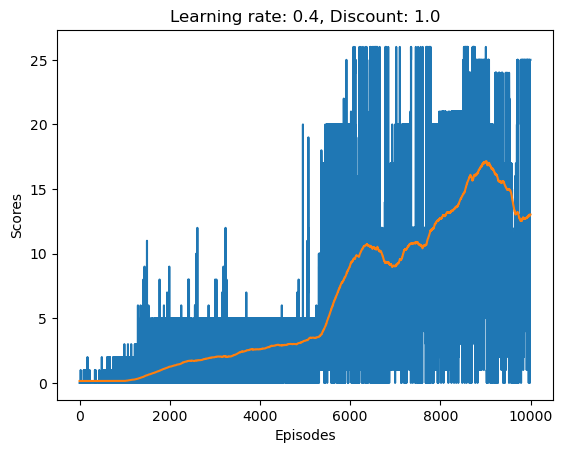

100%|██████████| 1/1 [00:00<00:00, 177.15it/s]


Game score: 25
-------------------
Learning rate: 0.4, Discount: 0.95


  4%|▎         | 361/10000 [00:00<00:05, 1841.48it/s]

0.49975


 14%|█▎        | 1373/10000 [00:01<00:07, 1214.21it/s]

0.3030757977143385


 22%|██▏       | 2180/10000 [00:01<00:09, 797.95it/s] 

0.18380177920996957


 30%|███       | 3035/10000 [00:04<00:15, 460.18it/s]

0.11146747544847624


 41%|████      | 4079/10000 [00:07<00:14, 420.87it/s]

0.0675999880755381


 50%|█████     | 5014/10000 [00:12<00:38, 128.00it/s]

0.04099633879234308


 61%|██████    | 6060/10000 [00:17<00:17, 224.60it/s]

0.02486242737940289


 70%|███████   | 7032/10000 [00:24<00:18, 161.26it/s]

0.015077938991750478


 80%|████████  | 8029/10000 [00:35<00:16, 118.02it/s]

0.009144088820035772


 90%|█████████ | 9024/10000 [00:43<00:08, 110.47it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:53<00:00, 185.72it/s]


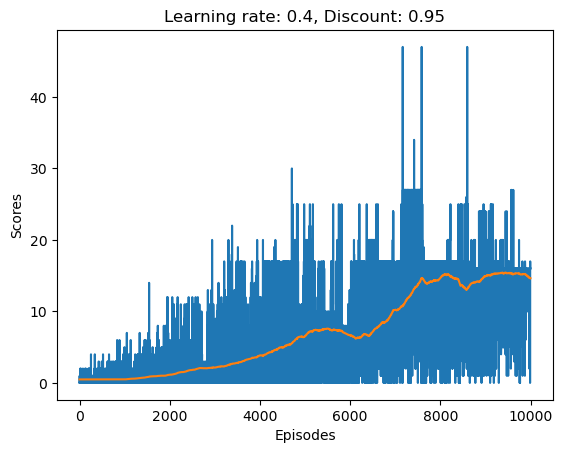

100%|██████████| 1/1 [00:00<00:00, 163.83it/s]


Game score: 16
-------------------
Learning rate: 0.4, Discount: 0.9


  6%|▌         | 556/10000 [00:00<00:03, 2799.73it/s]

0.49975


 11%|█         | 1089/10000 [00:00<00:04, 1976.67it/s]

0.3030757977143385


 21%|██        | 2100/10000 [00:01<00:07, 1046.52it/s]

0.18380177920996957


 31%|███       | 3108/10000 [00:03<00:14, 483.97it/s] 

0.11146747544847624


 41%|████      | 4053/10000 [00:06<00:22, 261.69it/s]

0.0675999880755381


 51%|█████     | 5051/10000 [00:10<00:17, 284.59it/s]

0.04099633879234308


 61%|██████    | 6074/10000 [00:14<00:13, 297.00it/s]

0.02486242737940289


 71%|███████   | 7070/10000 [00:21<00:14, 202.01it/s]

0.015077938991750478


 80%|████████  | 8028/10000 [00:27<00:16, 119.73it/s]

0.009144088820035772


 90%|█████████ | 9031/10000 [00:34<00:04, 222.60it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:40<00:00, 245.31it/s]


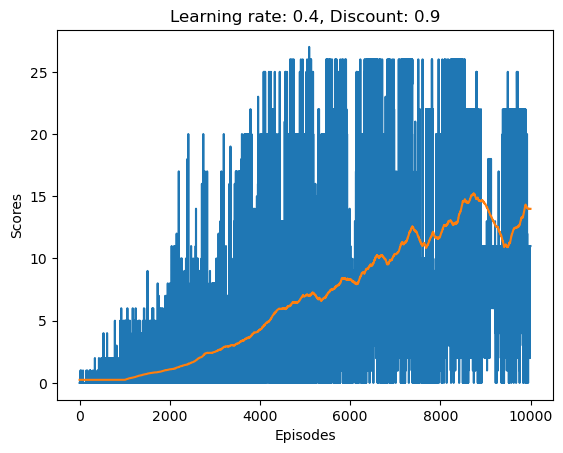

100%|██████████| 1/1 [00:00<00:00, 313.17it/s]


Game score: 2
-------------------
Learning rate: 0.4, Discount: 0.8


  4%|▎         | 352/10000 [00:00<00:05, 1765.96it/s]

0.49975


 12%|█▏        | 1212/10000 [00:00<00:06, 1430.24it/s]

0.3030757977143385


 20%|██        | 2032/10000 [00:01<00:10, 794.20it/s] 

0.18380177920996957


 31%|███       | 3086/10000 [00:04<00:13, 511.14it/s]

0.11146747544847624


 41%|████      | 4060/10000 [00:06<00:20, 292.16it/s]

0.0675999880755381


 51%|█████     | 5093/10000 [00:10<00:16, 291.69it/s]

0.04099633879234308


 61%|██████    | 6095/10000 [00:13<00:13, 288.81it/s]

0.02486242737940289


 70%|███████   | 7008/10000 [00:18<00:17, 170.35it/s]

0.015077938991750478


 81%|████████  | 8052/10000 [00:25<00:09, 212.53it/s]

0.009144088820035772


 91%|█████████ | 9087/10000 [00:27<00:01, 626.99it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:29<00:00, 338.37it/s]


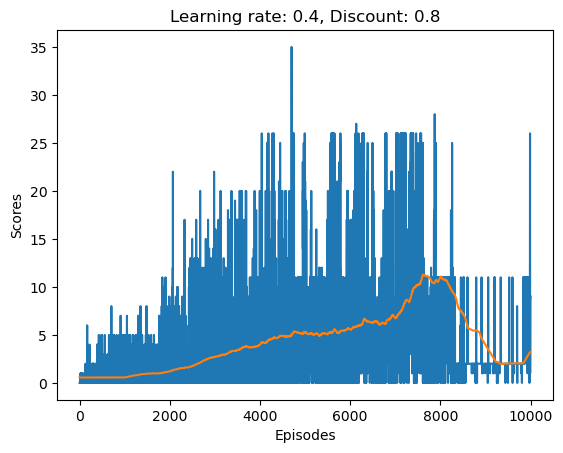

100%|██████████| 1/1 [00:00<00:00, 312.89it/s]


Game score: 9
-------------------
Learning rate: 0.4, Discount: 0.7


  5%|▌         | 518/10000 [00:00<00:04, 1932.15it/s]

0.49975


 12%|█▏        | 1160/10000 [00:00<00:08, 1031.48it/s]

0.3030757977143385


 22%|██▏       | 2232/10000 [00:02<00:09, 825.36it/s] 

0.18380177920996957


 31%|███       | 3073/10000 [00:03<00:12, 540.75it/s]

0.11146747544847624


 41%|████      | 4063/10000 [00:06<00:15, 384.59it/s]

0.0675999880755381


 51%|█████▏    | 5136/10000 [00:07<00:07, 644.38it/s]

0.04099633879234308


 60%|██████    | 6007/10000 [00:11<00:15, 258.96it/s]

0.02486242737940289


 71%|███████   | 7051/10000 [00:16<00:09, 306.90it/s]

0.015077938991750478


 80%|████████  | 8046/10000 [00:21<00:05, 327.49it/s]

0.009144088820035772


 90%|█████████ | 9005/10000 [00:29<00:15, 63.36it/s] 

0.005545476765388876


100%|██████████| 10000/10000 [00:36<00:00, 277.75it/s]


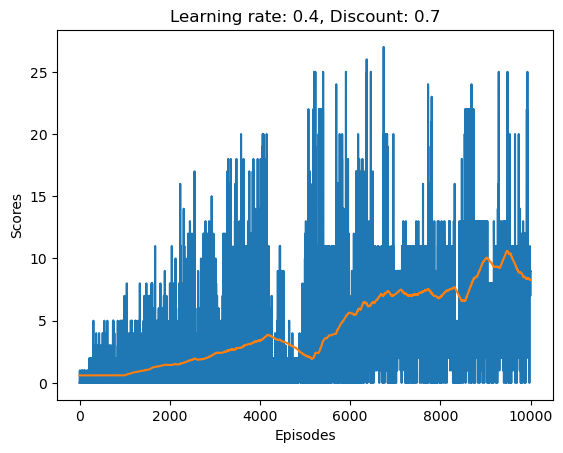

100%|██████████| 1/1 [00:00<00:00, 204.66it/s]


Game score: 9
-------------------
Learning rate: 0.6, Discount: 1.0


  3%|▎         | 337/10000 [00:00<00:05, 1748.53it/s]

0.49975


 12%|█▏        | 1198/10000 [00:01<00:09, 960.21it/s] 

0.3030757977143385


 21%|██        | 2071/10000 [00:02<00:14, 559.97it/s] 

0.18380177920996957


 31%|███       | 3104/10000 [00:04<00:15, 445.89it/s]

0.11146747544847624


 41%|████      | 4093/10000 [00:06<00:10, 537.64it/s]

0.0675999880755381


 51%|█████     | 5063/10000 [00:10<00:17, 288.00it/s]

0.04099633879234308


 61%|██████    | 6054/10000 [00:15<00:23, 171.08it/s]

0.02486242737940289


 70%|███████   | 7012/10000 [00:20<00:23, 129.11it/s]

0.015077938991750478


 81%|████████  | 8051/10000 [00:29<00:15, 122.62it/s]

0.009144088820035772


 90%|█████████ | 9039/10000 [00:37<00:07, 137.25it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:48<00:00, 206.77it/s]


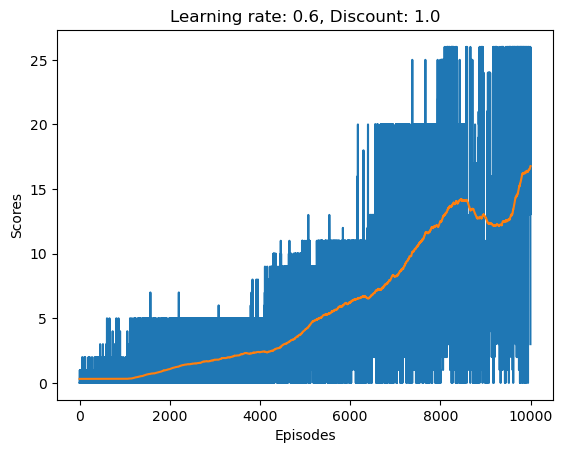

100%|██████████| 1/1 [00:00<00:00, 191.68it/s]


Game score: 26
-------------------
Learning rate: 0.6, Discount: 0.95


  6%|▌         | 578/10000 [00:00<00:03, 2494.17it/s]

0.49975


 11%|█▏        | 1145/10000 [00:00<00:09, 953.32it/s] 

0.3030757977143385


 21%|██        | 2107/10000 [00:02<00:19, 407.41it/s]

0.18380177920996957


 31%|███       | 3105/10000 [00:05<00:16, 410.46it/s]

0.11146747544847624


 40%|████      | 4007/10000 [00:07<00:30, 195.90it/s]

0.0675999880755381


 51%|█████     | 5052/10000 [00:13<00:16, 296.52it/s]

0.04099633879234308


 60%|██████    | 6040/10000 [00:18<00:21, 182.39it/s]

0.02486242737940289


 70%|███████   | 7016/10000 [00:24<00:35, 84.49it/s] 

0.015077938991750478


 80%|████████  | 8045/10000 [00:30<00:07, 258.75it/s]

0.009144088820035772


 90%|█████████ | 9032/10000 [00:38<00:05, 177.11it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:50<00:00, 199.95it/s]


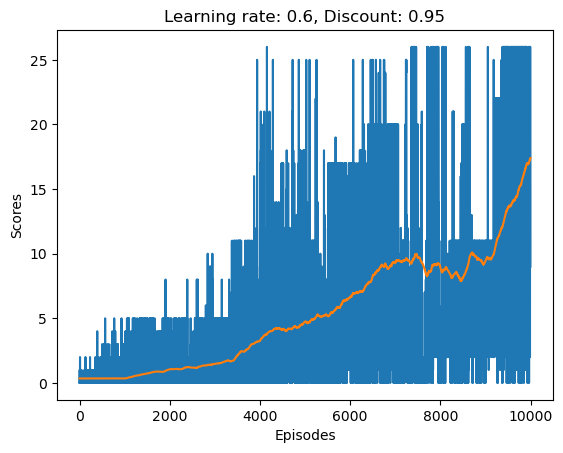

100%|██████████| 1/1 [00:00<00:00, 279.79it/s]


Game score: 7
-------------------
Learning rate: 0.6, Discount: 0.9


  2%|▏         | 190/10000 [00:00<00:05, 1893.60it/s]

0.49975


 13%|█▎        | 1285/10000 [00:00<00:06, 1296.49it/s]

0.3030757977143385


 21%|██▏       | 2130/10000 [00:02<00:13, 581.33it/s] 

0.18380177920996957


 31%|███▏      | 3137/10000 [00:04<00:14, 486.98it/s]

0.11146747544847624


 40%|████      | 4005/10000 [00:06<00:15, 383.42it/s]

0.0675999880755381


 51%|█████     | 5093/10000 [00:11<00:15, 310.34it/s]

0.04099633879234308


 61%|██████    | 6115/10000 [00:16<00:09, 404.56it/s]

0.02486242737940289


 70%|███████   | 7003/10000 [00:19<00:13, 219.28it/s]

0.015077938991750478


 80%|████████  | 8025/10000 [00:25<00:14, 132.27it/s]

0.009144088820035772


 91%|█████████ | 9094/10000 [00:34<00:03, 230.52it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:41<00:00, 243.33it/s]


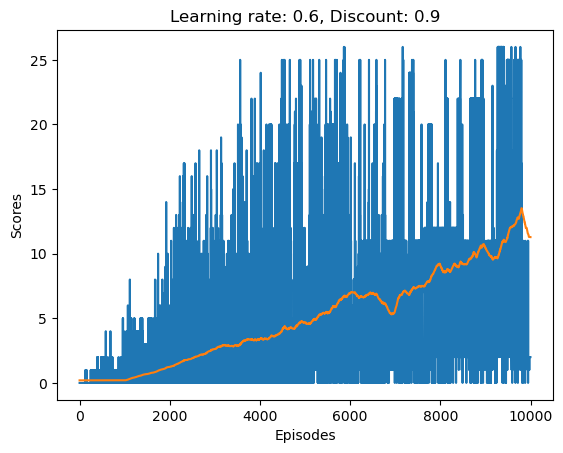

100%|██████████| 1/1 [00:00<00:00, 576.06it/s]


Game score: 2
-------------------
Learning rate: 0.6, Discount: 0.8


  3%|▎         | 312/10000 [00:00<00:06, 1422.99it/s]

0.49975


 13%|█▎        | 1313/10000 [00:01<00:08, 1019.23it/s]

0.3030757977143385


 21%|██        | 2109/10000 [00:02<00:13, 564.08it/s] 

0.18380177920996957


 31%|███       | 3063/10000 [00:05<00:25, 269.70it/s]

0.11146747544847624


 40%|████      | 4024/10000 [00:09<00:27, 218.16it/s]

0.0675999880755381


 50%|█████     | 5026/10000 [00:12<00:22, 220.45it/s]

0.04099633879234308


 60%|██████    | 6036/10000 [00:16<00:16, 238.40it/s]

0.02486242737940289


 71%|███████   | 7115/10000 [00:20<00:05, 549.67it/s]

0.015077938991750478


 81%|████████  | 8053/10000 [00:24<00:10, 182.73it/s]

0.009144088820035772


 90%|█████████ | 9032/10000 [00:29<00:06, 155.17it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:37<00:00, 264.48it/s]


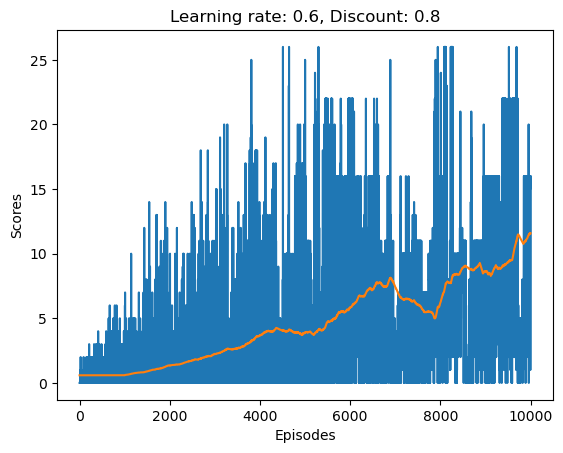

100%|██████████| 1/1 [00:00<00:00, 183.65it/s]


Game score: 16
-------------------
Learning rate: 0.6, Discount: 0.7


  3%|▎         | 337/10000 [00:00<00:05, 1735.13it/s]

0.49975


 12%|█▏        | 1210/10000 [00:00<00:07, 1133.18it/s]

0.3030757977143385


 21%|██        | 2109/10000 [00:01<00:09, 851.59it/s] 

0.18380177920996957


 31%|███       | 3060/10000 [00:03<00:13, 525.46it/s]

0.11146747544847624


 42%|████▏     | 4153/10000 [00:06<00:12, 471.35it/s]

0.0675999880755381


 51%|█████     | 5056/10000 [00:10<00:17, 275.18it/s]

0.04099633879234308


 60%|██████    | 6036/10000 [00:14<00:16, 242.08it/s]

0.02486242737940289


 70%|███████   | 7044/10000 [00:18<00:08, 353.55it/s]

0.015077938991750478


 80%|████████  | 8029/10000 [00:26<00:11, 164.73it/s]

0.009144088820035772


 90%|█████████ | 9050/10000 [00:33<00:02, 439.18it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:44<00:00, 223.13it/s]


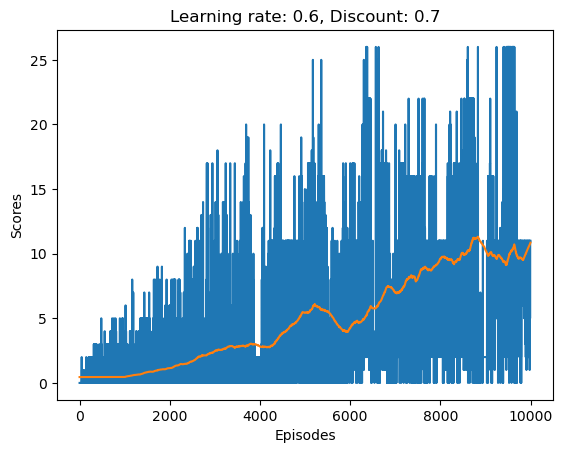

100%|██████████| 1/1 [00:00<00:00, 466.19it/s]


Game score: 2
-------------------
Learning rate: 0.8, Discount: 1.0


  5%|▍         | 482/10000 [00:00<00:04, 2353.06it/s]

0.49975


 12%|█▏        | 1160/10000 [00:00<00:04, 1970.95it/s]

0.3030757977143385


 22%|██▏       | 2195/10000 [00:01<00:07, 1042.75it/s]

0.18380177920996957


 33%|███▎      | 3270/10000 [00:02<00:07, 847.44it/s] 

0.11146747544847624


 40%|████      | 4037/10000 [00:04<00:22, 269.36it/s]

0.0675999880755381


 51%|█████     | 5064/10000 [00:07<00:15, 327.04it/s]

0.04099633879234308


 60%|██████    | 6047/10000 [00:11<00:14, 266.36it/s]

0.02486242737940289


 70%|███████   | 7030/10000 [00:16<00:07, 393.54it/s]

0.015077938991750478


 80%|████████  | 8017/10000 [00:19<00:08, 220.36it/s]

0.009144088820035772


 90%|█████████ | 9044/10000 [00:23<00:03, 269.42it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:31<00:00, 321.52it/s]


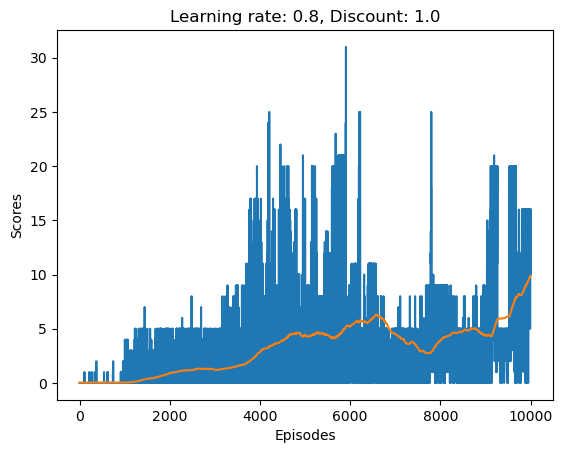

100%|██████████| 1/1 [00:00<00:00, 179.92it/s]


Game score: 16
-------------------
Learning rate: 0.8, Discount: 0.95


  3%|▎         | 292/10000 [00:00<00:07, 1374.22it/s]

0.49975


 12%|█▏        | 1170/10000 [00:01<00:09, 901.51it/s]

0.3030757977143385


 22%|██▏       | 2216/10000 [00:02<00:09, 817.16it/s]

0.18380177920996957


 31%|███       | 3075/10000 [00:03<00:16, 425.34it/s]

0.11146747544847624


 40%|████      | 4033/10000 [00:06<00:20, 293.39it/s]

0.0675999880755381


 51%|█████     | 5057/10000 [00:10<00:15, 309.84it/s]

0.04099633879234308


 61%|██████    | 6061/10000 [00:14<00:12, 311.96it/s]

0.02486242737940289


 70%|███████   | 7026/10000 [00:20<00:21, 136.26it/s]

0.015077938991750478


 80%|████████  | 8029/10000 [00:27<00:09, 216.63it/s]

0.009144088820035772


 90%|█████████ | 9020/10000 [00:32<00:07, 136.00it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:39<00:00, 255.27it/s]


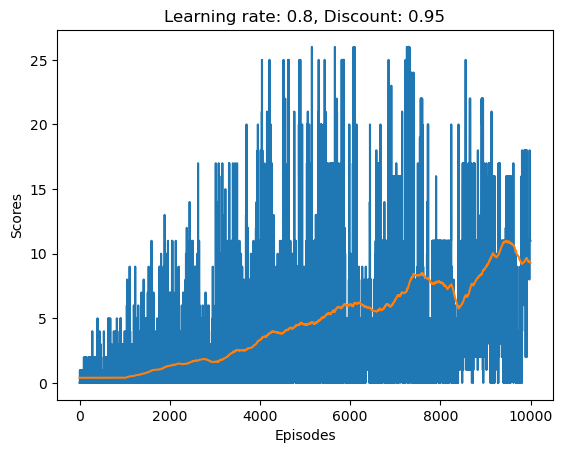

100%|██████████| 1/1 [00:00<00:00, 324.36it/s]


Game score: 11
-------------------
Learning rate: 0.8, Discount: 0.9


  3%|▎         | 274/10000 [00:00<00:07, 1317.23it/s]

0.49975


 14%|█▍        | 1422/10000 [00:01<00:07, 1158.10it/s]

0.3030757977143385


 22%|██▏       | 2227/10000 [00:02<00:10, 747.89it/s] 

0.18380177920996957


 31%|███▏      | 3135/10000 [00:04<00:11, 621.33it/s]

0.11146747544847624


 40%|████      | 4035/10000 [00:06<00:16, 363.47it/s]

0.0675999880755381


 50%|█████     | 5038/10000 [00:09<00:13, 371.35it/s]

0.04099633879234308


 61%|██████    | 6055/10000 [00:13<00:09, 396.18it/s]

0.02486242737940289


 70%|███████   | 7035/10000 [00:18<00:15, 193.78it/s]

0.015077938991750478


 81%|████████  | 8062/10000 [00:25<00:08, 239.77it/s]

0.009144088820035772


 91%|█████████ | 9099/10000 [00:31<00:02, 376.28it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:37<00:00, 265.97it/s]


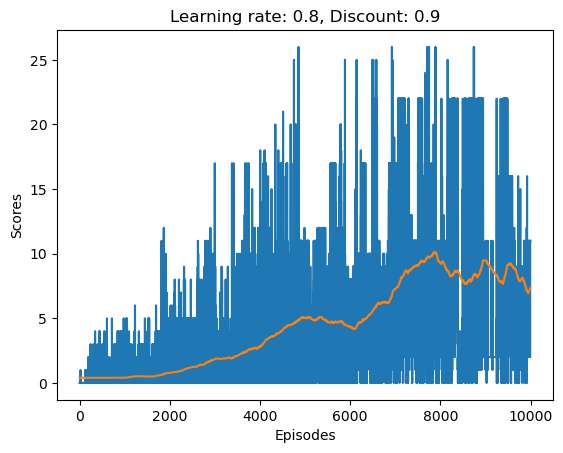

100%|██████████| 1/1 [00:00<00:00, 213.08it/s]


Game score: 11
-------------------
Learning rate: 0.8, Discount: 0.8


  1%|▏         | 141/10000 [00:00<00:07, 1399.56it/s]

0.49975


 12%|█▏        | 1195/10000 [00:01<00:08, 1096.83it/s]

0.3030757977143385


 22%|██▏       | 2173/10000 [00:02<00:12, 622.07it/s] 

0.18380177920996957


 30%|███       | 3049/10000 [00:04<00:22, 310.31it/s]

0.11146747544847624


 41%|████      | 4065/10000 [00:08<00:23, 255.37it/s]

0.0675999880755381


 50%|█████     | 5050/10000 [00:11<00:19, 258.92it/s]

0.04099633879234308


 60%|██████    | 6030/10000 [00:16<00:20, 194.81it/s]

0.02486242737940289


 70%|███████   | 7020/10000 [00:22<00:22, 130.30it/s]

0.015077938991750478


 81%|████████  | 8093/10000 [00:29<00:05, 358.19it/s]

0.009144088820035772


 90%|█████████ | 9033/10000 [00:34<00:04, 203.71it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:41<00:00, 241.19it/s]


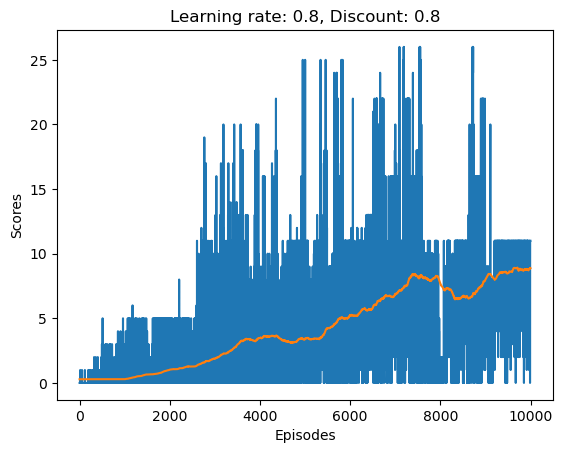

100%|██████████| 1/1 [00:00<00:00, 211.47it/s]


Game score: 11
-------------------
Learning rate: 0.8, Discount: 0.7


  3%|▎         | 298/10000 [00:00<00:07, 1337.86it/s]

0.49975


 13%|█▎        | 1281/10000 [00:01<00:09, 954.61it/s]

0.3030757977143385


 21%|██        | 2114/10000 [00:02<00:12, 623.91it/s] 

0.18380177920996957


 30%|███       | 3023/10000 [00:04<00:16, 434.96it/s]

0.11146747544847624


 41%|████      | 4079/10000 [00:07<00:21, 271.89it/s]

0.0675999880755381


 50%|█████     | 5043/10000 [00:11<00:15, 320.74it/s]

0.04099633879234308


 60%|██████    | 6019/10000 [00:17<00:28, 138.53it/s]

0.02486242737940289


 70%|███████   | 7022/10000 [00:26<00:20, 144.67it/s]

0.015077938991750478


 80%|████████  | 8040/10000 [00:31<00:09, 208.98it/s]

0.009144088820035772


 90%|█████████ | 9016/10000 [00:38<00:08, 109.35it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:46<00:00, 212.90it/s]


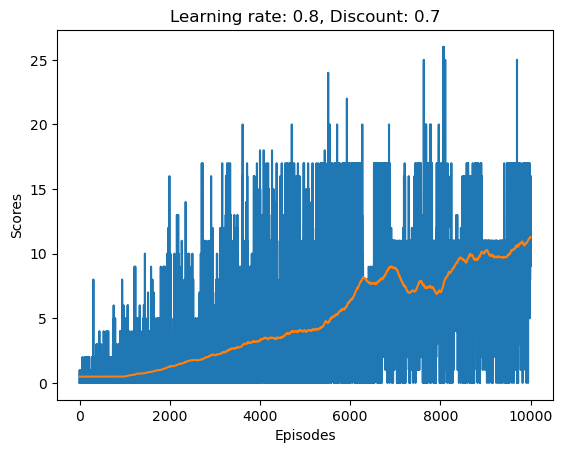

100%|██████████| 1/1 [00:00<00:00, 216.49it/s]


Game score: 16
-------------------
Learning rate: 0.9, Discount: 1.0


  0%|          | 27/10000 [00:00<00:38, 259.75it/s]

0.49975


 13%|█▎        | 1329/10000 [00:00<00:05, 1648.62it/s]

0.3030757977143385


 22%|██▏       | 2191/10000 [00:01<00:06, 1181.01it/s]

0.18380177920996957


 31%|███       | 3106/10000 [00:03<00:10, 632.75it/s] 

0.11146747544847624


 40%|████      | 4032/10000 [00:04<00:12, 486.01it/s]

0.0675999880755381


 50%|█████     | 5041/10000 [00:07<00:14, 342.40it/s]

0.04099633879234308


 61%|██████    | 6076/10000 [00:10<00:10, 359.22it/s]

0.02486242737940289


 70%|███████   | 7033/10000 [00:12<00:10, 278.66it/s]

0.015077938991750478


 80%|████████  | 8034/10000 [00:17<00:10, 182.45it/s]

0.009144088820035772


 90%|█████████ | 9039/10000 [00:22<00:05, 175.24it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:26<00:00, 378.96it/s]


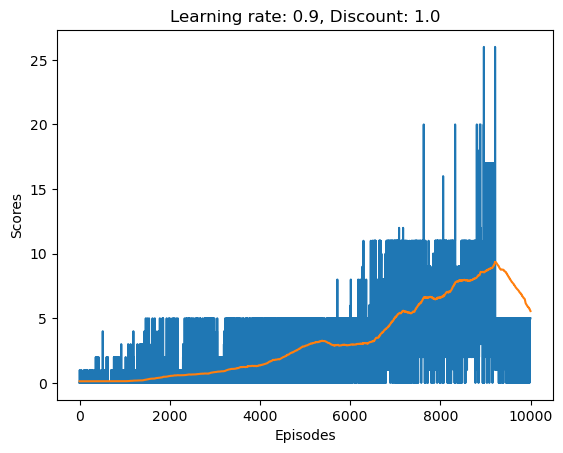

100%|██████████| 1/1 [00:00<00:00, 537.59it/s]


Game score: 5
-------------------
Learning rate: 0.9, Discount: 0.95


  2%|▏         | 173/10000 [00:00<00:05, 1729.29it/s]

0.49975


 12%|█▏        | 1198/10000 [00:00<00:06, 1380.16it/s]

0.3030757977143385


 22%|██▏       | 2167/10000 [00:01<00:07, 1045.34it/s]

0.18380177920996957


 31%|███       | 3088/10000 [00:03<00:09, 761.76it/s] 

0.11146747544847624


 41%|████      | 4078/10000 [00:05<00:14, 399.35it/s]

0.0675999880755381


 51%|█████     | 5101/10000 [00:07<00:09, 510.27it/s]

0.04099633879234308


 60%|██████    | 6047/10000 [00:10<00:20, 193.26it/s]

0.02486242737940289


 70%|███████   | 7044/10000 [00:15<00:13, 213.47it/s]

0.015077938991750478


 80%|████████  | 8021/10000 [00:20<00:11, 169.81it/s]

0.009144088820035772


 90%|█████████ | 9018/10000 [00:28<00:05, 186.14it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:36<00:00, 272.90it/s]


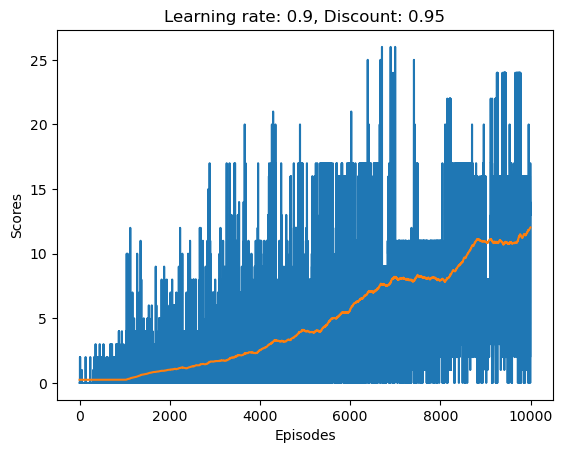

100%|██████████| 1/1 [00:00<00:00, 162.36it/s]


Game score: 16
-------------------
Learning rate: 0.9, Discount: 0.9


  3%|▎         | 347/10000 [00:00<00:05, 1787.25it/s]

0.49975


 12%|█▏        | 1232/10000 [00:00<00:08, 1077.00it/s]

0.3030757977143385


 21%|██▏       | 2135/10000 [00:02<00:12, 635.70it/s] 

0.18380177920996957


 30%|███       | 3020/10000 [00:04<00:15, 463.89it/s]

0.11146747544847624


 41%|████      | 4067/10000 [00:07<00:11, 508.93it/s]

0.0675999880755381


 52%|█████▏    | 5167/10000 [00:10<00:08, 549.84it/s]

0.04099633879234308


 60%|██████    | 6004/10000 [00:13<00:18, 215.92it/s]

0.02486242737940289


 70%|███████   | 7035/10000 [00:17<00:14, 203.82it/s]

0.015077938991750478


 81%|████████▏ | 8141/10000 [00:21<00:05, 354.99it/s]

0.009144088820035772


 90%|█████████ | 9029/10000 [00:24<00:03, 286.53it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:29<00:00, 344.31it/s]


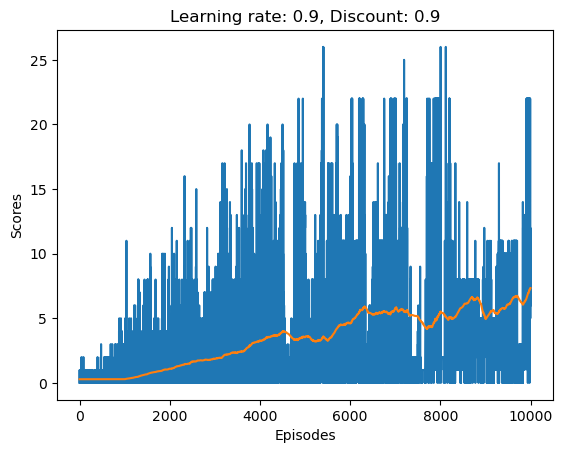

100%|██████████| 1/1 [00:00<00:00, 1034.35it/s]


Game score: 1
-------------------
Learning rate: 0.9, Discount: 0.8


  3%|▎         | 306/10000 [00:00<00:07, 1347.57it/s]

0.49975


 12%|█▏        | 1177/10000 [00:00<00:06, 1287.68it/s]

0.3030757977143385


 21%|██        | 2122/10000 [00:01<00:08, 893.88it/s] 

0.18380177920996957


 31%|███       | 3118/10000 [00:03<00:13, 527.06it/s]

0.11146747544847624


 41%|████      | 4115/10000 [00:05<00:09, 593.03it/s]

0.0675999880755381


 50%|█████     | 5033/10000 [00:08<00:24, 202.46it/s]

0.04099633879234308


 60%|██████    | 6040/10000 [00:12<00:18, 214.94it/s]

0.02486242737940289


 71%|███████   | 7072/10000 [00:16<00:13, 223.70it/s]

0.015077938991750478


 81%|████████  | 8076/10000 [00:21<00:06, 306.90it/s]

0.009144088820035772


 90%|█████████ | 9021/10000 [00:26<00:04, 200.77it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:33<00:00, 295.44it/s]


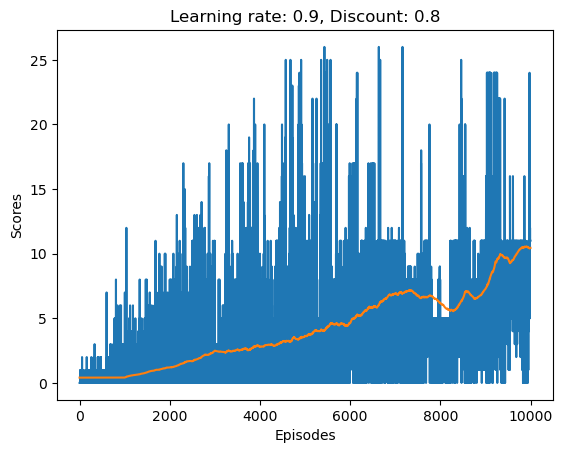

100%|██████████| 1/1 [00:00<00:00, 234.41it/s]


Game score: 11
-------------------
Learning rate: 0.9, Discount: 0.7


  2%|▏         | 224/10000 [00:00<00:08, 1149.70it/s]

0.49975


 11%|█▏        | 1126/10000 [00:00<00:07, 1157.24it/s]

0.3030757977143385


 21%|██        | 2077/10000 [00:02<00:11, 708.40it/s] 

0.18380177920996957


 32%|███▏      | 3199/10000 [00:03<00:09, 749.34it/s]

0.11146747544847624


 41%|████      | 4069/10000 [00:05<00:12, 489.75it/s]

0.0675999880755381


 51%|█████     | 5080/10000 [00:08<00:16, 304.70it/s]

0.04099633879234308


 61%|██████    | 6105/10000 [00:10<00:05, 661.41it/s]

0.02486242737940289


 70%|███████   | 7040/10000 [00:13<00:12, 235.08it/s]

0.015077938991750478


 81%|████████  | 8065/10000 [00:18<00:09, 209.57it/s]

0.009144088820035772


 91%|█████████ | 9090/10000 [00:22<00:01, 472.42it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:28<00:00, 352.57it/s]


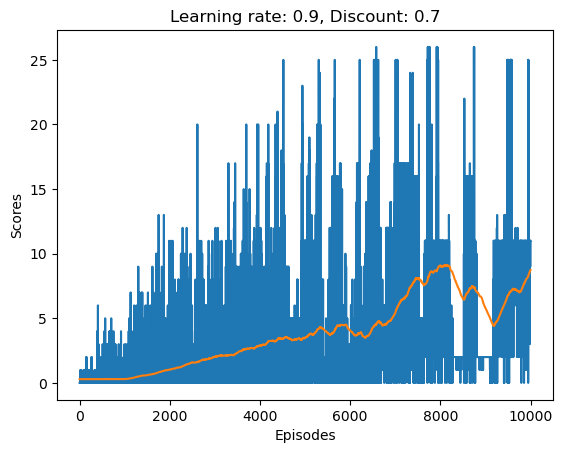

100%|██████████| 1/1 [00:00<00:00, 880.23it/s]

Game score: 2


In [99]:
hyper = {}
hyper['N_ACTIONS'] = 2
hyper['epsilon'] = 0.5
hyper['eps_decay'] = 0.9995
hyper['lr'] = 0
hyper['discount'] = 0
hyper['seed'] = None
hyper['rand_generator'] = np.random.RandomState(hyper['seed'])

list_lr = [0.4, 0.6, 0.8, 0.9]
list_discount = [1.0, 0.95, 0.9, 0.8, 0.7]
# labels_lr = ["lr = 0.4", "lr = 0.5","lr = 0.6", "lr = 0.7","lr = 0.8", "lr = 0.9"]
# labels_discount = ["discount = 1.0", "discount = 0.95","discount = 0.9", "discount = 0.85","discount = 0.8", "discount = 0.75", "discount = 0.7"]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=0)
game = QLearningAgent(hyper)
n_episodes = 10000

train_scores = []

for lr in list_lr:
    for discount in list_discount:
        print("-------------------")
        print(f"Learning rate: {lr}, Discount: {discount}")
        hyper['lr'] = lr
        hyper['discount'] = discount
        game = QLearningAgent(hyper)
        train_score = game.train(env, n_episodes)
        train_scores.append(train_score)
        window = 1000
        average_y = [np.mean(train_score[:window])]*window
        for ind in range(len(train_score) - window + 1):
            average_y.append(np.mean(train_score[ind:ind+window]))
        plt.plot(train_score)
        plt.plot(average_y)
        plt.xlabel("Episodes")
        plt.ylabel("Scores")
        plt.title(f"Learning rate: {lr}, Discount: {discount}")
        plt.show()
        _, test_score = game.test(env, 10)
        print("Game score:", test_score)

In [ ]:
hyper = {}
hyper['N_ACTIONS'] = 2
hyper['epsilon'] = 0.5
hyper['eps_decay'] = 0.9995
hyper['lr'] = 0 ###
hyper['discount'] = 0 ###
hyper['seed'] = None
hyper['rand_generator'] = np.random.RandomState(hyper['seed'])


env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=0)

game = QLearningAgent(hyper)
train_score = game.train(env, n_episodes)
window = 1000
average_y = [np.mean(train_score[:window])]*window
for ind in range(len(train_score) - window + 1):
    average_y.append(np.mean(train_score[ind:ind+window]))
plt.plot(train_score)
plt.plot(average_y)
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title(f"Q_Learning Algorithm: Train")
plt.show()
test_score,_ = game.test(env, 100)
window = 10
average_test_y = [np.mean(test_score[:window])]*window
for ind in range(len(test_score) - window + 1):
    average_test_y.append(np.mean(test_score[ind:ind+window]))
plt.plot(test_score)
plt.plot(average_test_y)
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title(f"Q_Learning Algorithm: Test")

In [14]:
# Convert dict Q to np array Q_ to save value in .csv file
def convert_Q(Q):
    Q_ = []
    for state in Q.keys():
        a = state[0][0]
        b = state[0][1]
        c = state[1]
        Q_.append([a,b,c,Q[((a,b),c)]])
    
    return np.array(Q_)

# Convert list Q_ from .csv file to dict Q
def convert_Q_(Q_):
    Q = defaultdict(lambda: 0)
    for row in Q_:
        [a,b,c,d] = row
        a,b,c = int(a), int(b), int(c)
        Q[((a,b), c)] = d
    return Q

Q_ = convert_Q(game.Q)
np.savetxt("Q_Learning_sameEnv.csv", Q_, delimiter =",")

0.001